In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import  pyplot as plt
import pickle
import os.path
import warnings
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
import warnings
from utils import *
import utils
warnings.filterwarnings("ignore")
projPath = './'
dataDir = f'{projPath}/db/'
modelDir = f'{projPath}/model/'

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(dataDir, train=False,  download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)
nTestSamples, width, height, channel = testset.data.shape
print(f'per image size: {width}*{height} | per image channel:{channel}')
Xtest = testset.data.reshape([nTestSamples, width*height*channel])
Ytest = torch.tensor(testset.targets)
print(f'Xtest  shape: {Xtest.shape} | Ytest shape: {Ytest.shape}')

per image size: 32*32 | per image channel:3
Xtest  shape: (10000, 3072) | Ytest shape: torch.Size([10000])


In [3]:
net = CNNCIFAR10()
criterion = torch.nn.CrossEntropyLoss()
# I trained with torch.nn.DataParallel
net = torch.nn.DataParallel(net)
netname=f'cifar10-cnn'
modelPath = modelDir+ 'best-{}-checkpoint.pth.tar'.format(netname)
checkpoint = torch.load(modelPath, map_location=torch.device('cpu'))
net.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# get some images

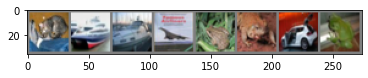

  cat  ship  ship plane  frog  frog   car  frog


In [4]:
def imshow(img, unnormalize=True):
    if unnormalize:
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

minibatch = iter(testloader).next()
images, labels = minibatch[0], minibatch[1]
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

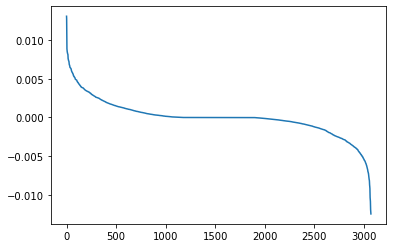

In [5]:
i = 1
img = images[[i]].requires_grad_()
label = labels[[i]]
output = net(img)
loss = criterion(output, label)
loss.backward()
imggradsorted = torch.sort(img.grad[0].view(-1,), descending=True)
plt.plot(range(len(imggradsorted.values)), imggradsorted.values)

In [6]:
def genAttack(images, labels, idx, stepsize=0.1, topK=60):
    i = idx
    img = images[[i]].requires_grad_()
    label = labels[[i]]
    output = net(img)
    loss = criterion(output, label)
    loss.backward()
    imggradsorted = torch.sort(img.grad[0].view(-1,), descending=True)
    plt.plot(range(len(imggradsorted.values)), imggradsorted.values)
    cidxs, rowidxs, colidxs = topbottomK(img.grad[0], topK)
    imgAttack = img.detach().clone()
    direction = img.grad[0, cidxs, rowidxs, colidxs].sign()
    imgAttack[0,cidxs, rowidxs, colidxs]  = torch.clamp(imgAttack[0,cidxs, rowidxs, colidxs] + 0.1 * direction, -1.0, 1.0)
    outputAttack = net(imgAttack)
    predOriginal, predAttack=output.data.max(1)[1], outputAttack.data.max(1)[1]
    pairs = torch.cat((img.detach(), imgAttack), 0)
    imshow(torchvision.utils.make_grid(pairs))
    print(f'  {classes[predOriginal]} | {classes[predAttack]}')

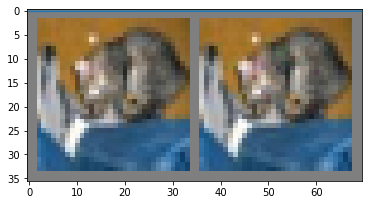

  cat | ship


In [7]:
genAttack(images, labels, 0, stepsize=0.1, topK=60)

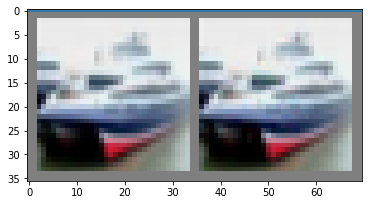

  ship | car


In [8]:
genAttack(images, labels, 1, stepsize=0.1, topK=60)

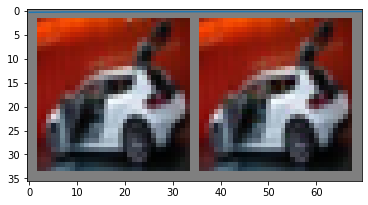

  car | dog


In [9]:
genAttack(images, labels, 6, stepsize=0.1, topK=60)

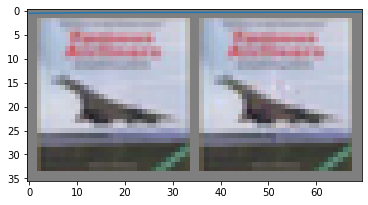

  ship | ship


In [10]:
genAttack(images, labels, 3, stepsize=0.1, topK=60)

In [37]:
# attack single pixel
# imgAttack = img.detach().clone()
# cidx, rowidx, colidx = getMaxIdx(img.grad[0])
# print(f'most positive gradient idx: {cidx}, {rowidx}, {colidx}')
# imgAttack[0, cidx, rowidx, colidx] = 1.0
# # imgAttack[0,1, rowidx, colidx] *= 0.1
# # imgAttack[0,2, rowidx, colidx] *= 0.1
# ha, rowidx, colidx = getMaxIdx(-img.grad[0])
# print(f'most neagtive gradient idx: {cidx}, {rowidx}, {colidx}')
# imgAttack[0,cidx, rowidx, colidx] =  0.0
# # imgAttack[0,0, rowidx, colidx] *= 1.1
# # imgAttack[0,1, rowidx, colidx] *= 1.1
# # imgAttack[0,2, rowidx, colidx] *= 1.1

In [38]:
# imgAttack = img.detach().clone()
# n = 1000
# rowidx = torch.randint(0,32, (n,))
# colidx = torch.randint(0,32, (n,))
# cidx = torch.randint(0,3, (n,))
# imgAttack[0, cidx, rowidx, colidx] *= 1.9